# SCENTInEL
#### sc ElasticNet transductive and inductive ensemble learning

# Subgraph weighting modules

##### Ver:: A2_V6
##### Author(s) : Issac Goh
##### Date : 220823;YYMMDD
### Author notes
    - Current defaults scrpae data from web, so leave as default and run
    - slices model and anndata to same feature shape, scales anndata object
    - added some simple benchmarking
    - creates dynamic cutoffs for probability score (x*sd of mean) in place of more memory intensive confidence scoring
    - Does not have majority voting set on as default, but module does exist
    - Multinomial logistic relies on the (not always realistic) assumption of independence of irrelevant alternatives whereas a series of binary logistic predictions does not. collinearity is assumed to be relatively low, as it becomes difficult to differentiate between the impact of several variables if this is not the case
    - Feel free to feed this model latent representations which capture non-linear relationships, the model will attempt to resolve any linearly seperable features. Feature engineering can be applied here.
    
### Features to add
    - Add ability to consume anndata zar format for sequential learning
### Modes to run in
    - Run in training mode
    - Run in projection mode

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scentinel as scent
import pickle as pkl
import matplotlib.pyplot as plt


#¢ new modules
import psutil
import time
import threading
from scipy.interpolate import UnivariateSpline
from queue import Queue, Empty
import scipy

Make sure that Python modules winreg, win32api or win32con are installed.
INFO: blas_opt_info:
INFO: blas_armpl_info:
INFO: customize UnixCCompiler
INFO:   libraries armpl_lp64_mp not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blas_mkl_info:
INFO:   libraries mkl_rt not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blis_info:
INFO:   libraries blis not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: openblas_info:
INFO:   libraries openblas not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: accelerate_info:
INFO:   NOT AVAILABLE
I

In [2]:
models = {
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'YS_wget':'https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav',
}

adatas_dict = {
'pan_fetal_wget':'https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
'YS_wget':'https://app.cellatlas.io/yolk-sac/dataset/23/download',
'YS_local':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad',
'YS_pre_agm':'https://app.cellatlas.io/yolk-sac/dataset/10/download',
'FLIV_wget':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
'int_atlas_sub':'/nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/example_notebooks/Simple_sampled_adata_V1.h5ad',
'int_atlas_full':'/nfs/team298/ar32/Thesis_lab_hdca/from_kemal/14_dataset_with_leiden.h5ad',
}

In [9]:
#setup global params:
# Variable assignment
train_model = False
adata_key = 'YS_local'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'new_example_model'#'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
#dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = 'LVL3'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = False # should data be normalised?

# setup model parameters:
model_params = {
'feat_use': 'LVL3',
'train_x_partition' : 'X_scvi', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
    
# Stratified Bayes sampler kwargs
'sample_data_knn':True,
'straify_sampling':False,
'knn_key' : 'neighbors',
'sampling_rate': 0.1,# Apply empirical bayes sampling weighted by knn?
'weight_penalty': 'laplacian_SGD_pagerank', # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
'iterations': 10,#How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
'representation_priority': 0.7, # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
'replace': True, # Allows model to clone cells
'equal_allocation': False, # Forces model to create equal representation sets
'resample_clones':True,
'pl_label_entropy':False,
}

In [ ]:
# load master graph
adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed='r')

#create some sub-graphs
adata_sub_dict = {}
adata.obs['age'].unique()
subs = ['6PCW', '7PCW']
for sub in subs:
    adata_sub_dict[sub] = adata[adata.obs['age'].isin([sub])].to_memory()


## Integrating Subgraph Information into a Main Graph

### Introduction

In single-cell transcriptomics, deciphering cellular heterogeneity often involves analyzing local neighborhoods within cellular similarity graphs. Our objective is to combine insights from multiple subgraphs into a primary graph, with a focus on leveraging the unique localized properties of each subgraph.

### Methodology

#### Local Density as a Measure of Significance:

Each node's local density in a subgraph serves as an indicator of its significance. Defined as:

$$\text{density}(i) = \sum_{j} w_{ij}$$

where \( w_{ij} \) is the weight of the edge connecting nodes \( i \) and \( j \), the local density captures the cumulative connection strengths of node \( i \). A higher density suggests the node's interactions are particularly pronounced in that subgraph, potentially hinting at unique cellular states or interactions.

#### Accumulative Integration:

To systematically integrate the subgraphs into the main graph, we employ an accumulator matrix, \( A \), of the same dimensions as the main matrix, initialized with zeros:

$$
A_{ij} = 0, \ \forall i,j
$$

The accumulator serves a dual purpose:

1. **Consolidation**: Aggregates weighted edge values from all subgraphs.
2. **Robustness**: Ensures that edges present in multiple subgraphs are treated uniformly, mitigating biases from the order of subgraph processing.

For each subgraph, the edge weights are multiplied by their starting node's local density, emphasizing edges in denser regions:

$$
A_{ij} \leftarrow A_{ij} + w_{ij} \times \text{density}(i)
$$

#### Geometric Mean Integration:

After accumulating values from all subgraphs, each edge in the main matrix, \( M \), is updated using the geometric mean of its original weight and the corresponding accumulated value:

$$
M_{ij} \leftarrow \sqrt{M_{ij} \times A_{ij}}
$$

The geometric mean is less sensitive to outliers than the arithmetic mean, offering a robust method to integrate values that may vary significantly across subgraphs.

#### Post-processing:

Finally, to maintain the integrity of the main graph:

1. The matrix is made symmetric.
2. Any self-loops are removed.

### Conclusion:

Our accumulative integration approach ensures that insights from all subgraphs are uniformly integrated into the main graph. By weighting edge updates with local densities, we emphasize connections that are particularly significant within their respective subgraphs, facilitating a richer understanding of cellular interactions.

--- 

You can now place this text, along with the LaTeX equations, into a Markdown document for your publication. If you have any further edits or questions, please let me know.

In [ ]:
import scipy.sparse as sp
def extract_connectivity_matrices(adata, adata_sub_dict, knn_key):
    """
    Extract the large matrix and the smaller matrices from the provided adata objects.
    """
    # Extract the main connectivity matrix from the main adata object
    main_matrix =  adata.obsp[adata.uns[model_params['knn_key']]['connectivities_key']]
    
    # Extract the smaller matrices from the subsetted adata objects
    sub_matrices = {sub:  sub_adata.obsp[sub_adata.uns[model_params['knn_key']]['connectivities_key']] for sub, sub_adata in adata_sub_dict.items()}
    
#     sub_adata.obsp[sub_adata.uns[model_params['knn_key']]['connectivities_key']]
#     adata.obsp[adata.uns[model_params['knn_key']]['connectivities_key']]
    return main_matrix, sub_matrices


def compute_density(matrix):
    """
    Compute the local density for each cell in the provided matrix.
    Density is defined as the sum of connectivity weights in a row.
    """
    return matrix.sum(axis=1).A1

def geometric_mean_weighted_update(main_matrix, sub_matrix, sub_density):
    """
    Update the main matrix using the geometric mean weighted by the local density from the sub_matrix.
    """
    rows, cols = sub_matrix.nonzero()
    for i, j in zip(rows, cols):
        # Compute the geometric mean weighted by the local density
        sub_weight = sub_matrix[i, j] * sub_density[i]
        main_weight = main_matrix[i, j] if i < main_matrix.shape[0] and j < main_matrix.shape[1] else 0
        update_weight = np.sqrt(main_weight * sub_weight)
        main_matrix[i, j] = update_weight

    return main_matrix


def get_node_mapping(main_barcodes, sub_barcodes):
    """
    Determine the mapping of nodes from the sub-matrix to the main matrix.
    """
    return {i: main_barcodes.index(sub_barcodes[i]) for i in range(len(sub_barcodes))}

def accumulate_subgraph_weights_mapped(main_matrix, adata_sub_dict, main_barcodes):
    """
    Accumulate the weighted edge values from all subgraphs into an accumulator matrix.
    Ensures the correct mapping of nodes between subgraphs and the main graph.
    """
    # Initialize the accumulator with zeros in CSR format
    accumulator = sp.lil_matrix(main_matrix.shape, dtype=np.float32)
    
    for sub_key, sub_adata in adata_sub_dict.items():
        print('Processing subgraph {}'.format(sub_key))
        
        # Extract barcodes for the subgraph
        sub_barcodes = list(sub_adata.obs.index)
        
        # Determine the node mapping from subgraph to main graph
        mapping = get_node_mapping(main_barcodes, sub_barcodes)
        
        # Extract matrix from the sub_adata
        matrix =  sub_adata.obsp[sub_adata.uns[model_params['knn_key']]['connectivities_key']]
        
        # Compute the density for the smaller matrix
        sub_density = compute_density(matrix)
        
        # Apply sigmoid scaling to the density information
        sub_density = 1 / (1 + np.exp(-sub_density))
        
        # Create a diagonal matrix with densities to multiply with the subgraph matrix
        density_diag = sp.diags(sub_density)
        
        # Compute the weighted matrix
        weighted_matrix = matrix.dot(density_diag)
        
        # Map the weighted matrix values to the accumulator using advanced indexing
        print("mapping the weighted matrix to the accumulator for subgraph {}".format(sub_key))
        i_sub, j_sub = weighted_matrix.nonzero()
        i_main = [mapping[i] for i in i_sub]
        j_main = [mapping[j] for j in j_sub]
        accumulator[i_main, j_main] += weighted_matrix[i_sub, j_sub]

    return accumulator.tocsr()

def integrate_matrices_mapped_optimized(adata, main_matrix, adata_sub_dict):
    """
    Integrate the information from all subgraphs into the main matrix ensuring correct node mapping.
    Optimized to handle sparse matrix structure.
    """
    # Extract barcodes for the main graph
    main_barcodes = list(adata.obs.index)
    
    # Accumulate the weighted edge values from all subgraphs
    accumulator = accumulate_subgraph_weights_mapped(main_matrix, adata_sub_dict, main_barcodes)

    # Identify overlapping non-zero entries between main_matrix and accumulator
    overlapping_nonzeros = main_matrix.multiply(accumulator)
    overlapping_rows, overlapping_cols = overlapping_nonzeros.nonzero()

    # Compute the geometric mean for overlapping entries using advanced indexing
    overlapping_values_main = main_matrix[overlapping_rows, overlapping_cols].A1  # Convert matrix to 1D array
    overlapping_values_acc = accumulator[overlapping_rows, overlapping_cols].A1    # Convert matrix to 1D array

    geometric_means = np.sqrt(overlapping_values_main * overlapping_values_acc)

    # Update the main matrix with the computed geometric means
    main_matrix[overlapping_rows, overlapping_cols] = geometric_means

    # Ensure the matrix is symmetric and remove any self-loops
    main_matrix = (main_matrix + main_matrix.T) / 2
    main_matrix.setdiag(0)
    
    return combined_matrix

# Extract matrices from adata objects
main_matrix, sub_matrices = extract_connectivity_matrices(adata, adata_sub_dict, model_params['knn_key'])

# Integrate the matrices using the single-pass approach
integrated_matrix_single_pass = integrate_matrices_mapped_optimized(adata, main_matrix, adata_sub_dict)

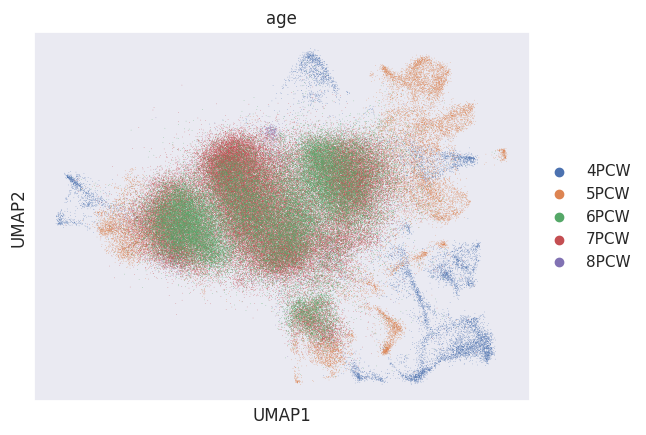

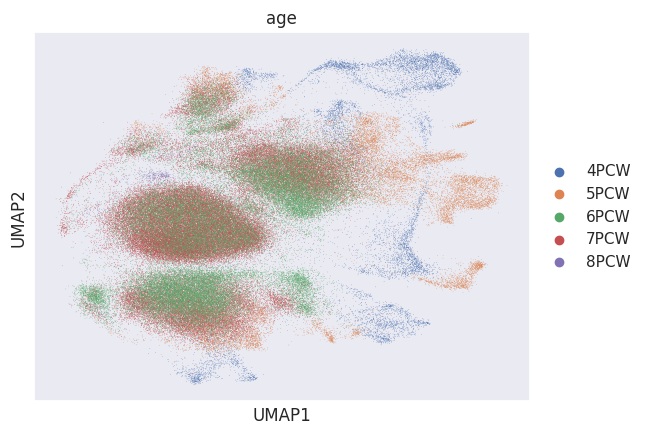

In [137]:
sc.pl.umap(adata,color = 'age')
sc.pl.umap(adata_orig,color = 'age')

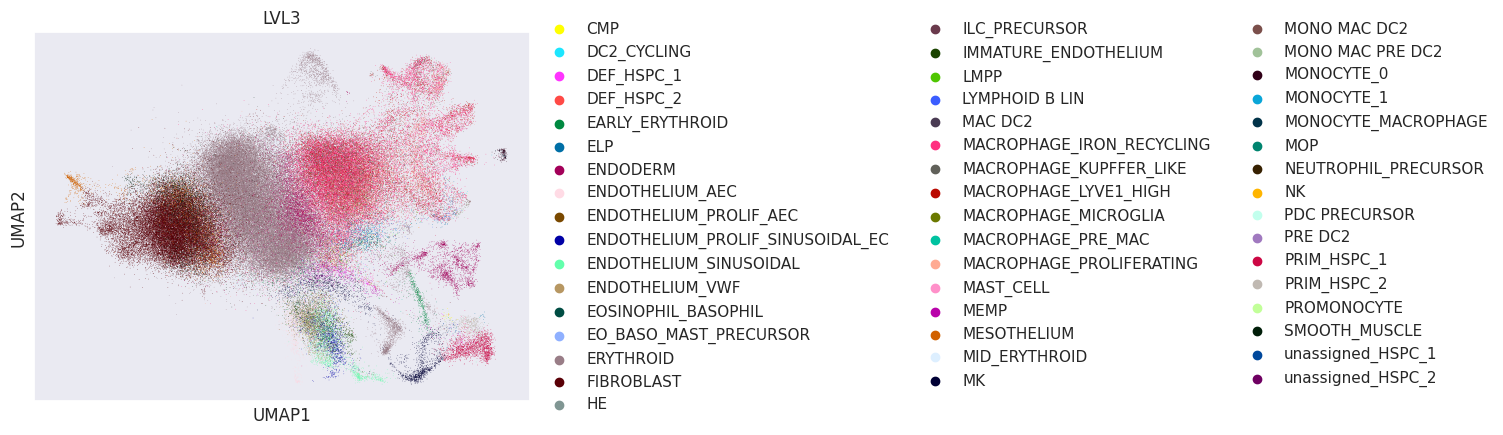

In [130]:
adata.obsp['connectivities'] = integrated_matrix_single_pass
sc.tl.umap(adata)
sc.pl.umap(adata,color = 'LVL3')

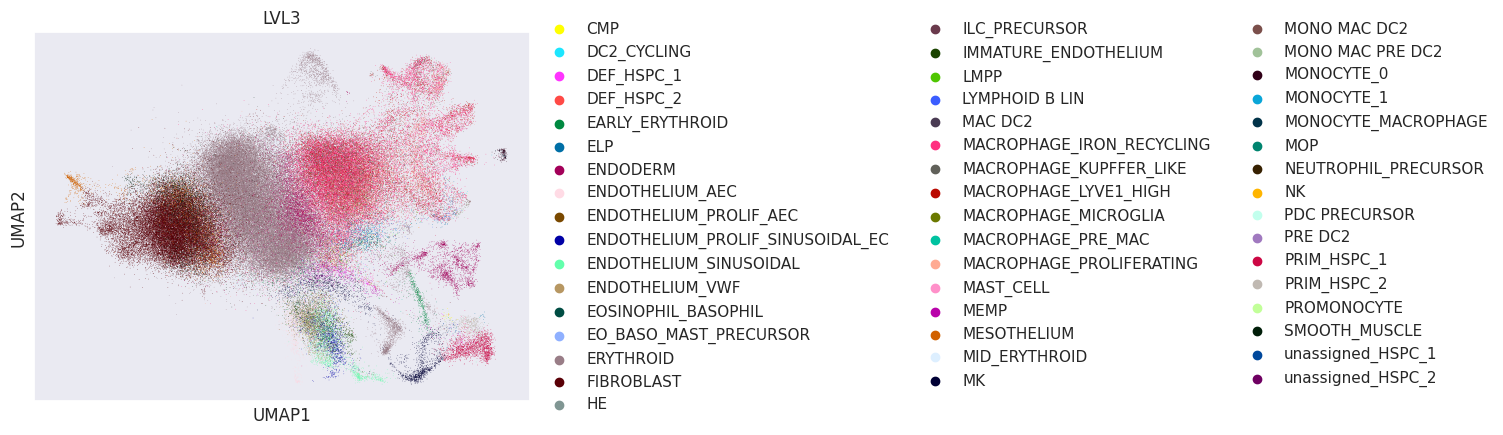

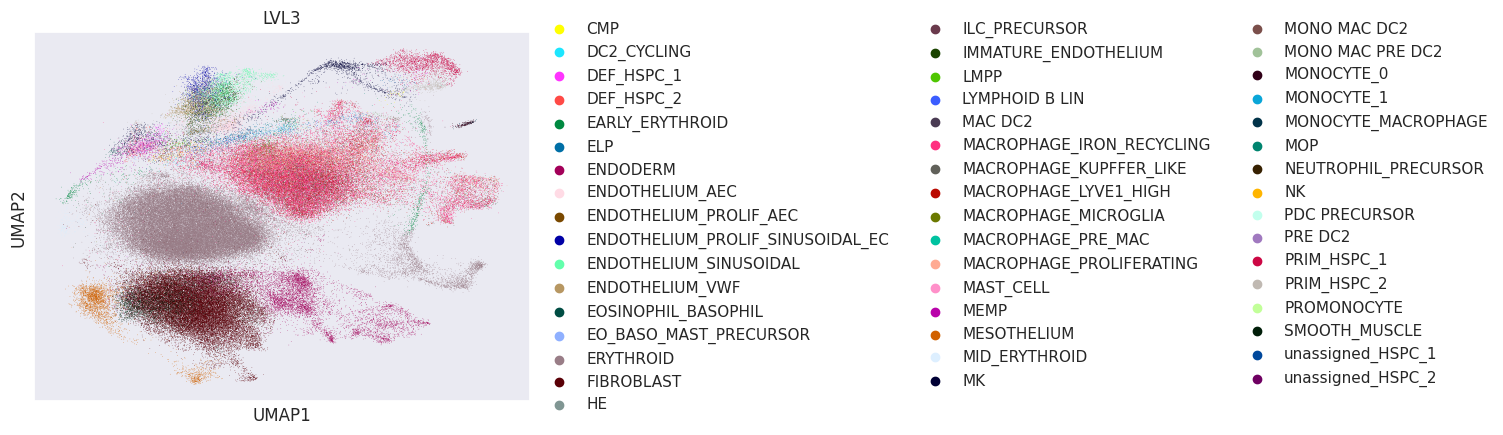

In [92]:
adata_orig = adata.to_memory()
adata.obsp['connectivities'] = integrated_matrix_single_pass
sc.tl.umap(adata)
sc.tl.umap(adata_orig)
sc.pl.umap(adata,color = 'LVL3')
sc.pl.umap(adata_orig,color = 'LVL3')